1. Imports & Global Settings

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd

from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

2. Data Loading, Time-of-Day Bucketing & Round Assignment

In [2]:
usecols = [
    'Time','HomeTeam','AwayTeam','FTHG','FTAG','FTR','Referee',
    'HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR',
    'B365H','B365D','B365A','B365>2.5','B365<2.5'
]

file_path = r"D:\python\premier league predictor\premier league data\premier leaguer 23-24.csv"
df = pd.read_csv(file_path, usecols=usecols)

# 2.1) match index + round (10 matches / round)
df['MatchIndex'] = df.index + 1
df['Round'] = np.ceil(df['MatchIndex'] / 10).astype(int)

# 2.2) time of day buckets
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce').dt.hour
bins = [-1, 11, 17, 24]
labels = ['Morning','Afternoon','Evening']
df['TimeOfDay'] = pd.cut(df['Hour'], bins=bins, labels=labels)
df.drop(columns='Hour', inplace=True)

# 2.3) safety cleanup (replace ±inf → NaN to avoid issues later)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

print("Loaded shape:", df.shape)

Loaded shape: (380, 27)


3. Leakage-Free Feature Engineering

In [3]:
# 3.1) targets
df['Outcome'] = df['FTR'].map({'H': 1, 'D': 0, 'A': -1})
df['Over2.5'] = ((df['FTHG'] + df['FTAG']) >= 3).astype(int)

# 3.2) implied probabilities (row-wise normalization)
for s in ['H','D','A']:
    df[f'ImpProb_{s}'] = 1.0 / df[f'B365{s}']

prob_cols = ['ImpProb_H','ImpProb_D','ImpProb_A']
row_sum = df[prob_cols].sum(axis=1)
mask = row_sum > 0
df.loc[mask, prob_cols] = df.loc[mask, prob_cols].div(row_sum[mask], axis=0)

df['ImpOver2.5']  = 1.0 / df['B365>2.5']
df['ImpUnder2.5'] = 1.0 / df['B365<2.5']
ou_sum = df[['ImpOver2.5','ImpUnder2.5']].sum(axis=1)
mask = ou_sum > 0
df.loc[mask, ['ImpOver2.5','ImpUnder2.5']] = df.loc[mask, ['ImpOver2.5','ImpUnder2.5']].div(ou_sum[mask], axis=0)

# 3.3) rolling forms (3-match, shift(1))
df['HomeForm3'] = (
    (df['FTHG'] - df['FTAG'])
      .groupby(df['HomeTeam'])
      .apply(lambda s: s.shift(1).rolling(3, min_periods=1).apply(lambda x: np.sign(x).mean(), raw=True))
      .reset_index(level=0, drop=True)
)
df['AwayForm3'] = (
    (df['FTAG'] - df['FTHG'])
      .groupby(df['AwayTeam'])
      .apply(lambda s: s.shift(1).rolling(3, min_periods=1).apply(lambda x: np.sign(x).mean(), raw=True))
      .reset_index(level=0, drop=True)
)

# 3.4) streaks (shift(1))
def _streak(s):
    run, out = 0, []
    for v in s:
        if pd.isna(v) or v == 0:
            run = 0
        else:
            v = np.sign(v)
            run = run + v if (len(out) and out[-1] != 0 and np.sign(out[-1]) == v) else v
        out.append(run)
    return pd.Series(out, index=s.index)

df['HomeStreak'] = (
    df.groupby('HomeTeam')['Outcome']
      .apply(lambda s: _streak(s.shift(1)))
      .reset_index(level=0, drop=True)
)
df['AwayStreak'] = (
    df.groupby('AwayTeam')['Outcome']
      .apply(lambda s: _streak((-s).shift(1)))
      .reset_index(level=0, drop=True)
)

# 3.5) odds spread + interaction
df['OddsSpread']  = df['ImpProb_H'] - df['ImpProb_A']
df['Spread×Form'] = df['OddsSpread'] * df['HomeForm3']

# 3.6) referee bias (historical home-win rate, shift(1))
ref_cum_homewins = (
    df.assign(HomeWin=df['Outcome'].eq(1).astype(int))
      .groupby('Referee')['HomeWin']
      .cumsum()
      .shift(1)
)
ref_counts = df.groupby('Referee').cumcount()
df['RefBias'] = (ref_cum_homewins / ref_counts.replace(0, np.nan)).fillna(0.5)

# 3.7) head-to-head last (home perspective)
df['PairKey'] = df.apply(lambda r: tuple(sorted([r['HomeTeam'], r['AwayTeam']])), axis=1)
_h2h_last = {}
def _prev_h2h(row):
    key = row['PairKey']
    prev = _h2h_last.get(key, 0.0)
    sign = 1 if row['HomeTeam'] == key[0] else -1
    _h2h_last[key] = row['Outcome'] * sign
    return prev if row['HomeTeam'] == key[0] else -prev
df['H2H_Last'] = df.apply(_prev_h2h, axis=1)

# 3.8) previous-round league positions (simple cumulative points)
home_pts = df['Outcome'].map({1:3, 0:1, -1:0})
away_pts = df['Outcome'].map({1:0, 0:1, -1:3})

_tmp = []
for i, r in df.iterrows():
    _tmp.append({'Team': r['HomeTeam'], 'Round': r['Round'], 'Pts': home_pts.iloc[i]})
    _tmp.append({'Team': r['AwayTeam'], 'Round': r['Round'], 'Pts': away_pts.iloc[i]})
_tab = pd.DataFrame(_tmp)
_tab['CumPts'] = _tab.groupby('Team')['Pts'].cumsum()
_tab['Pos']    = _tab.groupby('Round')['CumPts'].rank(method='min', ascending=False)

_prev = _tab[['Team','Round','Pos']].rename(columns={'Round':'PrevRound','Pos':'PrevPos'})
_prev['PrevRound'] += 1

df = df.merge(_prev, left_on=['HomeTeam','Round'], right_on=['Team','PrevRound'], how='left')
df['HomePosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team','PrevRound','PrevPos'], inplace=True)

df = df.merge(_prev, left_on=['AwayTeam','Round'], right_on=['Team','PrevRound'], how='left')
df['AwayPosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team','PrevRound','PrevPos'], inplace=True)

# 3.9) rolling team stats (3-match, shift(1))
for s in ['HS','HST','HF','HC','HY','HR']:
    df[f'Home_{s}_3'] = (
        df.groupby('HomeTeam')[s]
          .apply(lambda x: x.shift(1).rolling(3, min_periods=1).mean())
          .reset_index(level=0, drop=True)
    )
for s in ['AS','AST','AF','AC','AY','AR']:
    df[f'Away_{s}_3'] = (
        df.groupby('AwayTeam')[s]
          .apply(lambda x: x.shift(1).rolling(3, min_periods=1).mean())
          .reset_index(level=0, drop=True)
    )

# 3.10) categorical hygiene (keep strings; CatBoost will handle)
for c in ['HomeTeam','AwayTeam','Referee','TimeOfDay']:
    if c in df.columns:
        df[c] = df[c].astype(str).fillna('missing')

# 3.11) feature lists (no imputation here)
cat_feats = ['HomeTeam','AwayTeam','Referee','TimeOfDay']
num_feats = [
    'HomeForm3','AwayForm3','HomeStreak','AwayStreak',
    'ImpProb_H','ImpProb_D','ImpProb_A',
    'ImpOver2.5','ImpUnder2.5',
    'OddsSpread','Spread×Form','RefBias','H2H_Last',
    'HomePosPrev','AwayPosPrev'
] + [f'Home_{s}_3' for s in ['HS','HST','HF','HC','HY','HR']] \
  + [f'Away_{s}_3' for s in ['AS','AST','AF','AC','AY','AR']]


4. Pipeline Specification & CatBoost Hyperparameter Distribution

In [4]:
# 4.1) helper: categorical column indices for CatBoost
cat_idx = list(range(len(cat_feats)))  # X will be [cat_feats + num_feats]

# 4.2) base model (fixed defaults; no OHE, CatBoost handles categories)
base_params = dict(
    loss_function='MultiClass',
    eval_metric='Accuracy',          # (marad a kompromisszum a CV-ben)
    random_state=RANDOM_STATE,
    iterations=600,                  # ↓ was 1200
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=10.0,
    rsm=0.8,
    bootstrap_type='Bayesian',
    bagging_temperature=1.0,
    use_best_model=True,             # ← enable best-iteration rollback
    early_stopping_rounds=50,        # ← stop early on eval_set
    allow_writing_files=False,
    verbose=False,
    thread_count=4                   # ← limit threads to avoid CPU oversubscription
)

def make_cb_model():
    return CatBoostClassifier(**base_params)

# 4.3) randomized search space (time-series CV, multi-metric scoring)
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import loguniform, uniform

tscv = TimeSeriesSplit(n_splits=3)

param_distributions = {
    'learning_rate': loguniform(1e-2, 1e-1),
    'depth': [6, 8, 10],
    'l2_leaf_reg': loguniform(1.0, 30.0),
    # 'subsample': uniform(0.6, 0.4),  # ← REMOVE for Bayesian bootstrap
    'rsm': uniform(0.6, 0.4),
    'bagging_temperature': uniform(0.0, 2.0),
}

def make_rand_search():
    scorers = {'bal_acc': 'balanced_accuracy', 'acc': 'accuracy'}
    return RandomizedSearchCV(
        estimator=make_cb_model(),
        param_distributions=param_distributions,
        n_iter=20,          # ↓ was 40
        cv=tscv,
        scoring=scorers,
        refit='bal_acc',
        n_jobs=1,           # ← run CatBoost trainings serially; each uses thread_count cores
        random_state=RANDOM_STATE,
        verbose=0
    )

5. Round-by-Round Training & Prediction with Tuning

In [5]:
from sklearn.metrics import accuracy_score
import numpy as np

# containers
preds, actuals, rounds, match_indices = [], [], [], []

# warm-up: first 5 rounds (~10 matches/round)
WARMUP_ROUNDS = 5
WARMUP_MATCHES = WARMUP_ROUNDS * 10

X_warm = df.loc[:WARMUP_MATCHES-1, cat_feats + num_feats]
y_warm = df.loc[:WARMUP_MATCHES-1, 'Outcome']
cat_idx = list(range(len(cat_feats)))

# 5.1) build validation slice for warm-up (last full warm-up round if possible)
val_round = WARMUP_ROUNDS
val_mask = (df['Round'] == val_round) & (df.index < WARMUP_MATCHES)

if val_mask.sum() >= 10:
    X_val_warm = df.loc[val_mask, cat_feats + num_feats]
    y_val_warm = df.loc[val_mask, 'Outcome']
    train_mask_warm = (df.index < WARMUP_MATCHES) & (~val_mask)
    X_tr_warm = df.loc[train_mask_warm, cat_feats + num_feats]
    y_tr_warm = df.loc[train_mask_warm, 'Outcome']
else:
    split_idx = int(len(X_warm) * 0.9)
    X_tr_warm, y_tr_warm = X_warm.iloc[:split_idx], y_warm.iloc[:split_idx]
    X_val_warm, y_val_warm = X_warm.iloc[split_idx:], y_warm.iloc[split_idx:]

# 5.2) initial warm-up fit (with eval_set for early stopping)
_ = make_cb_model().fit(
    X_tr_warm, y_tr_warm,
    cat_features=cat_idx,
    eval_set=(X_val_warm, y_val_warm),
    verbose=False
)

# 5.3) predict from round 6 onward
max_round = int(df['Round'].max())
for r in range(WARMUP_ROUNDS + 1, max_round + 1):
    train_mask = df['Round'] < r
    test_mask  = df['Round'] == r

    # build training slice
    X_train = df.loc[train_mask, cat_feats + num_feats]
    y_train = df.loc[train_mask, 'Outcome']

    # build test slice for this round, enforce exactly 10 matches
    round_df = df.loc[test_mask, :].sort_values(['Round', 'MatchIndex'])
    if len(round_df) > 10:
        round_df = round_df.head(10)
    if len(round_df) < 10:
        print(f"Round {r}: only {len(round_df)} matches available → skipped.")
        continue

    X_test = round_df[cat_feats + num_feats]
    y_test = round_df['Outcome']

    # build validation slice (last round before r, else 90/10 split)
    val_round = r - 1
    val_mask = (df['Round'] == val_round) & train_mask
    if val_mask.sum() >= 10:
        X_val = df.loc[val_mask, cat_feats + num_feats]
        y_val = df.loc[val_mask, 'Outcome']
        train_mask_adj = train_mask & (~val_mask)
        X_train = df.loc[train_mask_adj, cat_feats + num_feats]
        y_train = df.loc[train_mask_adj, 'Outcome']
    else:
        split_idx = int(len(X_train) * 0.9)
        X_val = X_train.iloc[split_idx:]
        y_val = y_train.iloc[split_idx:]
        X_train = X_train.iloc[:split_idx]
        y_train = y_train.iloc[:split_idx]

    # log progress
    print(f"Round {r}: training={len(X_train)} | val={len(X_val)} | test=10 ...")

    # randomized search with CatBoost
    rand_search = make_rand_search()
    rand_search.fit(
        X_train, y_train,
        cat_features=cat_idx,
        eval_set=(X_val, y_val),
        verbose=False
    )
    model = rand_search.best_estimator_

    # predict exactly 10 matches
    y_pred = model.predict(X_test)

    # collect results
    preds.extend(np.asarray(y_pred).ravel().tolist())
    actuals.extend(y_test.tolist())
    rounds.extend([r] * len(y_test))  # always 10
    match_indices.extend(round_df['MatchIndex'].tolist())

    # per-round accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Round {r}: 10 matches | accuracy = {acc:.3f}")

print(f"Predicted rounds {WARMUP_ROUNDS + 1}–{max_round} (10 matches each)")

# expose final trained model and last training round
final_model = model
last_train_round = max_round - 1


Round 6: training=40 | val=10 | test=10 ...


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2801: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2801: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2801: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2801: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2801

Round 6: 10 matches | accuracy = 0.500
Round 7: training=50 | val=10 | test=10 ...
Round 7: 10 matches | accuracy = 0.400
Round 8: training=60 | val=10 | test=10 ...
Round 8: 10 matches | accuracy = 0.400
Round 9: training=70 | val=12 | test=10 ...
Round 9: 10 matches | accuracy = 0.600
Round 10: training=82 | val=10 | test=10 ...
Round 10: 10 matches | accuracy = 0.600
Round 11: training=92 | val=10 | test=10 ...
Round 11: 10 matches | accuracy = 0.400
Round 12: training=102 | val=10 | test=10 ...
Round 12: 10 matches | accuracy = 0.600
Round 13: training=112 | val=10 | test=10 ...
Round 13: 10 matches | accuracy = 0.400
Round 14: training=122 | val=10 | test=10 ...
Round 14: 10 matches | accuracy = 0.600
Round 15: training=132 | val=10 | test=10 ...
Round 15: 10 matches | accuracy = 0.400
Round 16: training=142 | val=10 | test=10 ...
Round 16: 10 matches | accuracy = 0.500
Round 17: training=152 | val=10 | test=10 ...
Round 17: 10 matches | accuracy = 0.700
Round 18: training=162 | v

6. Assemble, Save Results & Final Model

In [6]:
import pandas as pd
from joblib import dump

# 6.1) rebuild basic match info
df_idx = df.set_index('MatchIndex')
home_list = [df_idx.loc[i, 'HomeTeam'] for i in match_indices]
away_list = [df_idx.loc[i, 'AwayTeam'] for i in match_indices]

# 6.2) results dataframe
results_df = pd.DataFrame({
    'MatchIndex': match_indices,
    'Round':      rounds,
    'HomeTeam':   home_list,
    'AwayTeam':   away_list,
    'Actual':     actuals,
    'Predicted':  preds
}).sort_values(['Round','MatchIndex']).reset_index(drop=True)

# flatten Predicted values if they are lists/arrays (e.g., [[1], [0], ...] → [1, 0, ...])
results_df['Predicted'] = results_df['Predicted'].apply(
    lambda v: (v[0] if isinstance(v, (list, np.ndarray)) and len(v) == 1 else (v.item() if hasattr(v, 'shape') and np.size(v) == 1 else v))
)

# 6.3) label mapping (numeric → H/D/A)
label_map = {1: 'H', 0: 'D', -1: 'A'}
results_df['ActualLabel'] = results_df['Actual'].map(label_map)
results_df['PredLabel']   = results_df['Predicted'].map(label_map)

# 6.4) save predictions
preds_out_path = r"D:\python\premier league predictor\catboost_predictions_vs_actuals.xlsx"
results_df.to_excel(preds_out_path, index=False)
print("Saved predictions to:", preds_out_path)

# 6.5) persist final model
#   CatBoost supports both pickle/joblib and native .cbm; save both for convenience.
model_joblib_path = r"D:\python\premier league predictor\catboost_pl_pipeline.joblib"
dump(final_model, model_joblib_path)
print("Saved final model (joblib) to:", model_joblib_path)

model_cbm_path = r"D:\python\premier league predictor\catboost_pl_pipeline.cbm"
try:
    final_model.save_model(model_cbm_path, format="cbm")
    print("Saved final model (CatBoost .cbm) to:", model_cbm_path)
except Exception as e:
    print("CBM save skipped:", e)


Saved predictions to: D:\python\premier league predictor\catboost_predictions_vs_actuals.xlsx
Saved final model (joblib) to: D:\python\premier league predictor\catboost_pl_pipeline.joblib
Saved final model (CatBoost .cbm) to: D:\python\premier league predictor\catboost_pl_pipeline.cbm


7. Results & Visualization

C:\Users\markf\AppData\Local\Temp\ipykernel_22708\2564086679.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  round_acc = res.groupby('Round').apply(lambda g: accuracy_score(g['True'], g['Pred']))


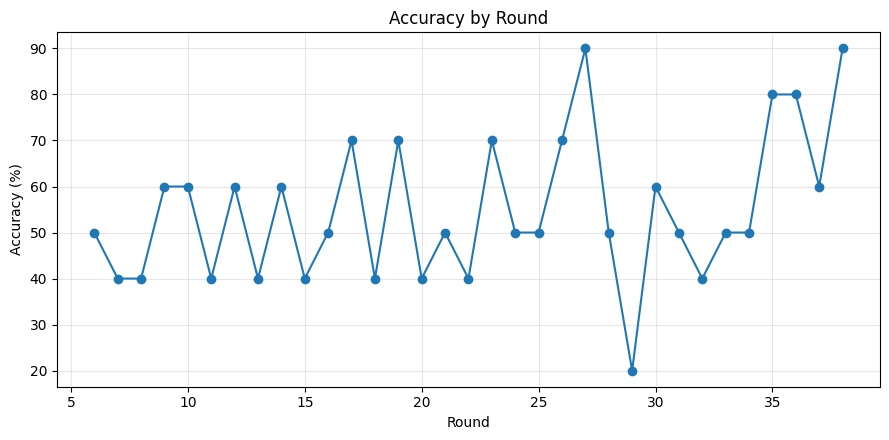

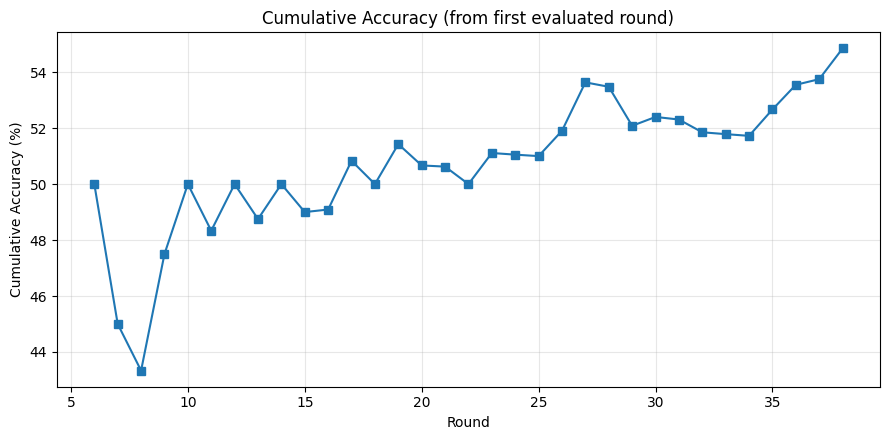


Overall accuracy (rounds 6–38): 0.548
Text summary: The model achieved an overall accuracy of 54.8% across rounds 6–38.

Classification report (labels: H=1, D=0, A=-1):
              precision    recall  f1-score   support

           1      0.591     0.724     0.651       152
           0      0.240     0.083     0.124        72
          -1      0.546     0.613     0.578       106

    accuracy                          0.548       330
   macro avg      0.459     0.473     0.451       330
weighted avg      0.500     0.548     0.512       330


Confusion matrix (rows=actual, cols=predicted) [H=1, D=0, A=-1]:
[[110  13  29]
 [ 41   6  25]
 [ 35   6  65]]


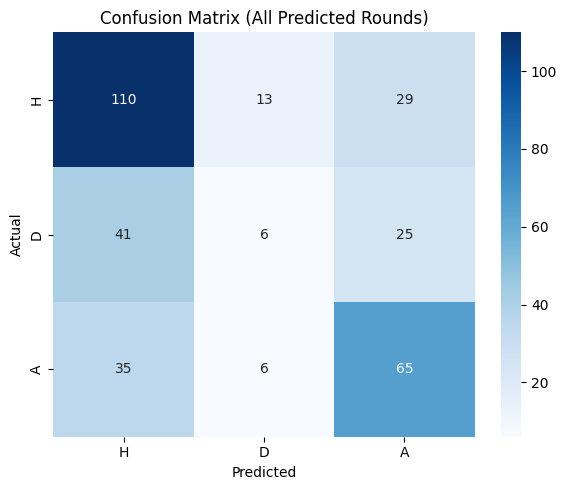

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 7.1) build results frame from point 5 collections
res = pd.DataFrame({
    'Round': rounds,
    'Pred': preds,
    'True': actuals
}).sort_values('Round')

# 7.2) sanity check: enforce 10 matches per evaluated round
round_sizes = res.groupby('Round').size()
if not np.all(round_sizes.values == 10):
    print("WARNING: Some evaluated rounds do not contain exactly 10 matches:")
    print(round_sizes[round_sizes != 10])

# 7.3) per-round accuracy (denominator = 10 by construction)
round_acc = res.groupby('Round').apply(lambda g: accuracy_score(g['True'], g['Pred']))
round_acc = round_acc.sort_index()

# 7.4) cumulative accuracy across rounds (running)
# running sum of correct predictions divided by (round_idx * 10)
res['Correct'] = (res['True'] == res['Pred']).astype(int)
correct_per_round = res.groupby('Round')['Correct'].sum().sort_index()
cum_correct = correct_per_round.cumsum()
cum_total = np.arange(1, len(cum_correct) + 1) * 10
cumulative_acc = (cum_correct / cum_total)

# 7.5) plot: accuracy by round
plt.figure(figsize=(9, 4.5))
plt.plot(round_acc.index, round_acc.values * 100, marker='o')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy by Round')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 7.6) plot: cumulative accuracy
plt.figure(figsize=(9, 4.5))
plt.plot(cumulative_acc.index, cumulative_acc.values * 100, marker='s')
plt.xlabel('Round')
plt.ylabel('Cumulative Accuracy (%)')
plt.title('Cumulative Accuracy (from first evaluated round)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 7.7) overall accuracy (text output)
overall_acc = accuracy_score(res['True'], res['Pred'])
print(f"\nOverall accuracy (rounds {int(res['Round'].min())}–{int(res['Round'].max())}): {overall_acc:.3f}")
print(f"Text summary: The model achieved an overall accuracy of {overall_acc*100:.1f}% "
      f"across rounds {int(res['Round'].min())}–{int(res['Round'].max())}.")

# 7.8) classification report (informative only)
print("\nClassification report (labels: H=1, D=0, A=-1):")
print(classification_report(res['True'], res['Pred'], labels=[1,0,-1], digits=3))

# 7.9) confusion matrix (numbers + heatmap)
cm = confusion_matrix(res['True'], res['Pred'], labels=[1,0,-1])
print("\nConfusion matrix (rows=actual, cols=predicted) [H=1, D=0, A=-1]:")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['H','D','A'], yticklabels=['H','D','A'])
plt.title('Confusion Matrix (All Predicted Rounds)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

8. Gradio Interface

In [8]:
import gradio as gr
import numpy as np
import pandas as pd

# 8.1) safety: last_train_round fallback
if 'last_train_round' not in globals():
    last_train_round = int(df['Round'].max()) - 1

# 8.2) training-slice means for odds-like features (leakage-safe defaults)
odd_feats = [
    'ImpProb_H','ImpProb_D','ImpProb_A',
    'ImpOver2.5','ImpUnder2.5','OddsSpread'
]
train_df = df[df['Round'] <= last_train_round].copy()
odd_means = train_df[odd_feats].mean(numeric_only=True)

# 8.3) dropdown choices
teams = sorted(df['HomeTeam'].dropna().unique().tolist())
refs  = sorted(df['Referee'].dropna().unique().tolist())
times = ['Morning','Afternoon','Evening']

# 8.4) helpers to fetch latest known states from training data
def _latest_row_team(team_name: str, side: str):
    if side == 'Home':
        rows = train_df[train_df.HomeTeam == team_name]
        if len(rows) == 0:
            rows = df[df.HomeTeam == team_name]
    else:
        rows = train_df[train_df.AwayTeam == team_name]
        if len(rows) == 0:
            rows = df[df.AwayTeam == team_name]
    return rows.iloc[-1] if len(rows) else None

def _latest_row_ref(ref_name: str):
    rows = train_df[train_df.Referee == ref_name]
    if len(rows) == 0:
        rows = df[df.Referee == ref_name]
    return rows.iloc[-1] if len(rows) else None

# 8.5) prediction function
def predict_outcome(home_team, away_team, referee, time_of_day):
    # guard: teams must differ
    if home_team == away_team:
        return "Pick two different teams.", 0.0, 0.0, 0.0

    # latest known rows
    home_row = _latest_row_team(home_team, 'Home')
    away_row = _latest_row_team(away_team, 'Away')
    ref_row  = _latest_row_ref(referee)
    if home_row is None or away_row is None or ref_row is None:
        return "Insufficient historical data to build features.", 0.0, 0.0, 0.0

    # assemble one-row feature dict
    feat = {}

    # odds-like defaults from training means
    for f in odd_feats:
        feat[f] = float(odd_means.get(f, np.nan))

    # interaction recomputed from mean probs and home form
    feat['OddsSpread']  = float(feat['ImpProb_H'] - feat['ImpProb_A'])
    home_form = home_row.get('HomeForm3')
    home_form = float(home_form) if pd.notna(home_form) else 0.0
    feat['Spread×Form'] = float(feat['OddsSpread'] * home_form)

    # rolling forms & streaks
    def _val(x, default=0.0):
        return float(x) if pd.notna(x) else default

    feat['HomeForm3']  = _val(home_row.get('HomeForm3'))
    feat['AwayForm3']  = _val(away_row.get('AwayForm3'))
    feat['HomeStreak'] = _val(home_row.get('HomeStreak'))
    feat['AwayStreak'] = _val(away_row.get('AwayStreak'))

    # referee bias & H2H last
    feat['RefBias']  = _val(ref_row.get('RefBias'), 0.5)
    feat['H2H_Last'] = 0.0
    mask = (
        ((df.HomeTeam == home_team) & (df.AwayTeam == away_team)) |
        ((df.HomeTeam == away_team) & (df.AwayTeam == home_team))
    )
    if mask.any():
        last_h2h = df.loc[mask].iloc[-1].get('H2H_Last', 0.0)
        feat['H2H_Last'] = _val(last_h2h, 0.0)

    # previous-round positions
    feat['HomePosPrev'] = _val(home_row.get('HomePosPrev'), df['Round'].max() + 1)
    feat['AwayPosPrev'] = _val(away_row.get('AwayPosPrev'), df['Round'].max() + 1)

    # rolling team stats (3-match means)
    for s in ['HS','HST','HF','HC','HY','HR']:
        key = f'Home_{s}_3'
        feat[key] = _val(home_row.get(key))
    for s in ['AS','AST','AF','AC','AY','AR']:
        key = f'Away_{s}_3'
        feat[key] = _val(away_row.get(key))

    # categoricals
    feat['HomeTeam']  = home_team
    feat['AwayTeam']  = away_team
    feat['Referee']   = referee
    feat['TimeOfDay'] = time_of_day

    # build DataFrame in the exact model column order
    cols = cat_feats + num_feats
    X_new = pd.DataFrame([feat], columns=cols)

    # predict probabilities with the final CatBoost model
    proba = final_model.predict_proba(X_new)[0]

    # map to Home / Draw / Away using class order learned by the model
    # CatBoost sklearn wrapper exposes classes_
    class_order = list(final_model.classes_)  # e.g. [-1, 0, 1]
    prob_map = {cls: p for cls, p in zip(class_order, proba)}

    home_pct = float(prob_map.get(1, 0.0) * 100.0)
    draw_pct = float(prob_map.get(0, 0.0) * 100.0)
    away_pct = float(prob_map.get(-1, 0.0) * 100.0)

    # summary line
    summary = (f"{home_team} vs {away_team} | Ref: {referee} | {time_of_day} | "
               f"Home: {home_pct:.1f}%  Draw: {draw_pct:.1f}%  Away: {away_pct:.1f}%")
    return summary, home_pct, draw_pct, away_pct

# 8.6) gradio interface
iface = gr.Interface(
    fn=predict_outcome,
    inputs=[
        gr.Dropdown(choices=teams, label="Home Team"),
        gr.Dropdown(choices=teams, label="Away Team"),
        gr.Dropdown(choices=refs,  label="Referee"),
        gr.Dropdown(choices=times, label="Time of Day")
    ],
    outputs=[
        gr.Textbox(label="Summary"),
        gr.Number(label="Home Win %"),
        gr.Number(label="Draw %"),
        gr.Number(label="Away Win %")
    ],
    title="Premier League Outcome Predictor (CatBoost)",
    description=(
        "Select Home/Away teams, Referee and Time of Day. "
        "Odds-like features default to training-set historical averages; "
        "all other features come from the most recent training data (no leakage)."
    )
)

# 8.7) launch
iface.launch()

* Running on local URL:  http://127.0.0.1:7870

To create a public link, set `share=True` in `launch()`.
